# Валидация моделей

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display="diagram")

from scipy.stats  import norm, ttest_ind
from scipy import stats

# from xgboost import XGBClassifier

import shap

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

import matplotlib.pyplot as plt
import seaborn as sns

import boto3
import os
import awswrangler as wr
import matplotlib.pyplot as plt

import joblib
import s3fs

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
data_file_name = "data_cleansed_2024-02-14 22:20:20.926766.parquet"

In [4]:
aws_key = os.environ['AWS_ACCESS_KEY_ID']
aws_secret = os.environ['AWS_SECRET_ACCESS_KEY']
endpoint_url = os.environ['AWS_ENDPOINT_URL']
bucket_name = 'mlops-hw3-vos'
s3 = boto3.resource(
    's3',
    aws_access_key_id=aws_key,
    aws_secret_access_key=aws_secret,
    endpoint_url=endpoint_url,
)
bucket = s3.Bucket(bucket_name)
data_file_name = "data_cleansed_2024-02-14 22:20:20.926766.parquet"

In [5]:
path_ = f"s3://{bucket_name}/{data_file_name}"

In [10]:
df = pd.read_parquet(path_)

In [11]:
df.head(5)

,tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
0,1832792695,2022-11-04 15:12:51,58,190,13.42,101142771,1170,0,0
1,1832793055,2022-11-04 16:21:39,289,568,71.22,101146899,1170,0,0
2,1832793162,2022-11-04 13:01:13,356,996,77.00,101134873,1170,0,0
3,1832793237,2022-11-04 13:48:53,395,556,12.11,101137733,1170,0,0
4,1832793343,2022-11-04 22:14:53,463,324,1.47,101168093,1170,0,0


In [12]:
df = df.sample(frac=0.1, random_state=1)

In [13]:
df['tx_fraud'].value_counts()

tx_fraud
0    4438584
1     131033
Name: count, dtype: int64

In [14]:
len(df)

4569617

In [15]:
df_sample = df.sample(frac=0.1, random_state=1)

In [16]:
df_sample.head(4)

,tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
25713145,1837861708,2022-11-07 12:02:30,236433,334,46.18,101390550,1173,0,0
44744561,1864129747,2022-11-24 16:33:50,3532,886,48.51,102875630,1190,0,0
30987941,1843896454,2022-11-11 11:33:25,87424,884,5.04,101734405,1177,0,0
42051416,1837376554,2022-11-06 20:34:35,926101,231,20.63,101334875,1172,0,0


In [17]:
feature_cols = ["terminal_id", "tx_amount", "tx_time_seconds", "tx_time_days"]
target_col = "tx_fraud"

X = df_sample[feature_cols]
y = df_sample[target_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    random_state=42,
    n_jobs=1,
)

pipe = Pipeline(steps=[
    ("classifier", rf_clf),
])
pipe

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=15, n_estimators=50, n_jobs=1,
                                        random_state=42))])

In [20]:
from sklearn.metrics import roc_auc_score
pipe.fit(X_train, y_train);
y_pred = pipe.predict(X_test)

P, R, F1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
roc_auc = roc_auc_score(y_test, y_pred)
print(f"P: {P:.2f}, R: {R:.2f}, F1: {F1:.5f}, AUC: {roc_auc:.5f}")

P: 1.00, R: 0.39, F1: 0.55964, AUC: 0.69427


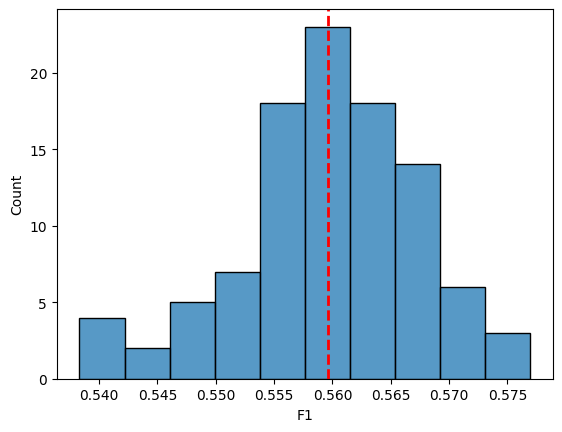

In [21]:
from sklearn.metrics import roc_auc_score
np.random.seed(42)

bootstrap_iterations = 100

df1 = pd.DataFrame(data={
    "y_test": y_test,
    "y_pred": y_pred,
})

scores = pd.DataFrame(data={
    "F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0
}, index=range(bootstrap_iterations))

for i in range(bootstrap_iterations):
    sample = df1.sample(frac=1.0, replace=True)
    scores.loc[i, "F1"] = f1_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "P"] = precision_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "R"] = recall_score(sample["y_test"], sample["y_pred"])
    scores.loc[i, "AUC"] = roc_auc_score(sample["y_test"], sample["y_pred"])

ax = sns.histplot(
    x=scores["F1"] 
)

ax.axvline(x=F1, color="red", linestyle="dashed", linewidth=2);

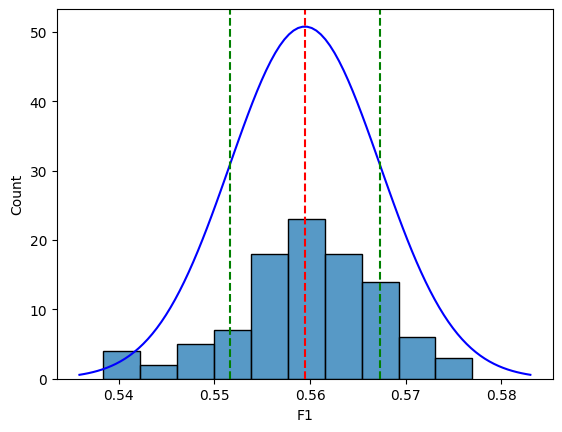

In [22]:
f1_mean = scores["F1"].mean()
f1_std = scores["F1"].std()


f1_low = f1_mean - 3 * f1_std
f1_upp = f1_mean + 3 * f1_std


ax = sns.histplot(
    x=scores["F1"] 
)

x = np.linspace(f1_low, f1_upp, 100)
y = norm.pdf(x, loc=f1_mean, scale=f1_std)
ax.plot(x, y, color="blue")
ax.axvline(f1_mean, color="red", linestyle='dashed')
ax.axvline(f1_mean-f1_std, color="green", linestyle='dashed')
ax.axvline(f1_mean+f1_std, color="green", linestyle='dashed');

plt.gcf()
plt.savefig("h1.png", transparent=True)

## Подбор гипрепараметров

In [23]:
params_grid = {
    "classifier__n_estimators": range(50, 70, 10),
    "classifier__max_depth": range(15, 20),
}

random_search_res = RandomizedSearchCV(
    pipe,
    params_grid,
    n_iter=100,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42,
).fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [33]:
from io import BytesIO 

def write_joblib(file, path):
    ''' 
       Function to write a joblib file to an s3 bucket or local directory.
       Arguments:
       * file: The file that you want to save 
       * path: an s3 bucket or local directory path. 
    '''

    # Path is an s3 bucket
    if path[:5] == 's3://':
        s3_bucket, s3_key = path.split('/')[2], path.split('/')[3:]
        s3_key = '/'.join(s3_key)
        with BytesIO() as f:
            joblib.dump(file, f)
            f.seek(0)
            boto3.client("s3").upload_fileobj(Bucket=bucket, Key=s3_key, Fileobj=f)
    
    # Path is a local directory 
    else:
        with open(path, 'wb') as f:
            joblib.dump(file, f)

In [37]:
# Write
fs = s3fs.S3FileSystem()
output_file = os.path.join(f"s3://{bucket_name}", "random_search_res_short.joblib")

with fs.open(output_file, 'wb') as f:
    joblib.dump(random_search_res, f)

# Read
# with fs.open(output_file, 'rb') as f:
#     random_search_res = joblib.load(f)

In [38]:
random_search_res.best_params_

{'classifier__n_estimators': 50, 'classifier__max_depth': 19}

In [39]:
y_pred_candidate = random_search_res.predict(X_test)
P_candidate, R_candidate, F1_candidate, _ = precision_recall_fscore_support(y_test, y_pred_candidate, average="binary")
print(f"P_candidate: {P_candidate:.2f}, R_candidate: {R_candidate:.2f}, F1_candidate: {F1_candidate:.5f}")

P_candidate: 1.00, R_candidate: 0.51, F1_candidate: 0.67821


$$n = \frac{2(Z_{\alpha / 2} + Z_{\beta})^2 \sigma^2}{\delta^2}$$

$Z_{\alpha / 2}$ - критическое значение, соответствующее искомому уровню значимости $\alpha / 2$. Берется $\alpha / 2$ потому, что мы рассматриваем двусторонний тест. Значение $\alpha$ определяет уровень допустимости ошибки первого рода. Как правило $\alpha$ берется 0.05 для обычных исследовний и 0.01 для случая медицинских исследований или иных, где ошибка первого рода (отвергнута верная нулевая гипотеза) является критически важной.

$Z_\beta$ - критическое значение, соотвествующее заданному уровню статистической мощности. Значение $\beta$ определяет вероятность ошибки второго рода (принята неверная нулевая гипотеза). Как правило $\beta$ устанавливается на уровне 0.8 или 0.9.

$\sigma$ - стандартное отклонение

$\delta$ - размер эффекта, который необходимо выловить

In [40]:
from sklearn.metrics import roc_auc_score
df_cand = pd.DataFrame(data={
    "y_test": y_test,
    "y_pred": y_pred_candidate,
})

scores_cand = pd.DataFrame(data={
    "F1": 0.0, "P": 0.0, "R": 0.0, "AUC": 0.0
}, index=range(bootstrap_iterations))

for i in range(bootstrap_iterations):
    sample = df_cand.sample(frac=1.0, replace=True)
    scores_cand.loc[i, "F1"] = f1_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "P"] = precision_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "R"] = recall_score(sample["y_test"], sample["y_pred"])
    scores_cand.loc[i, "AUC"] = roc_auc_score(sample["y_test"], sample["y_pred"])

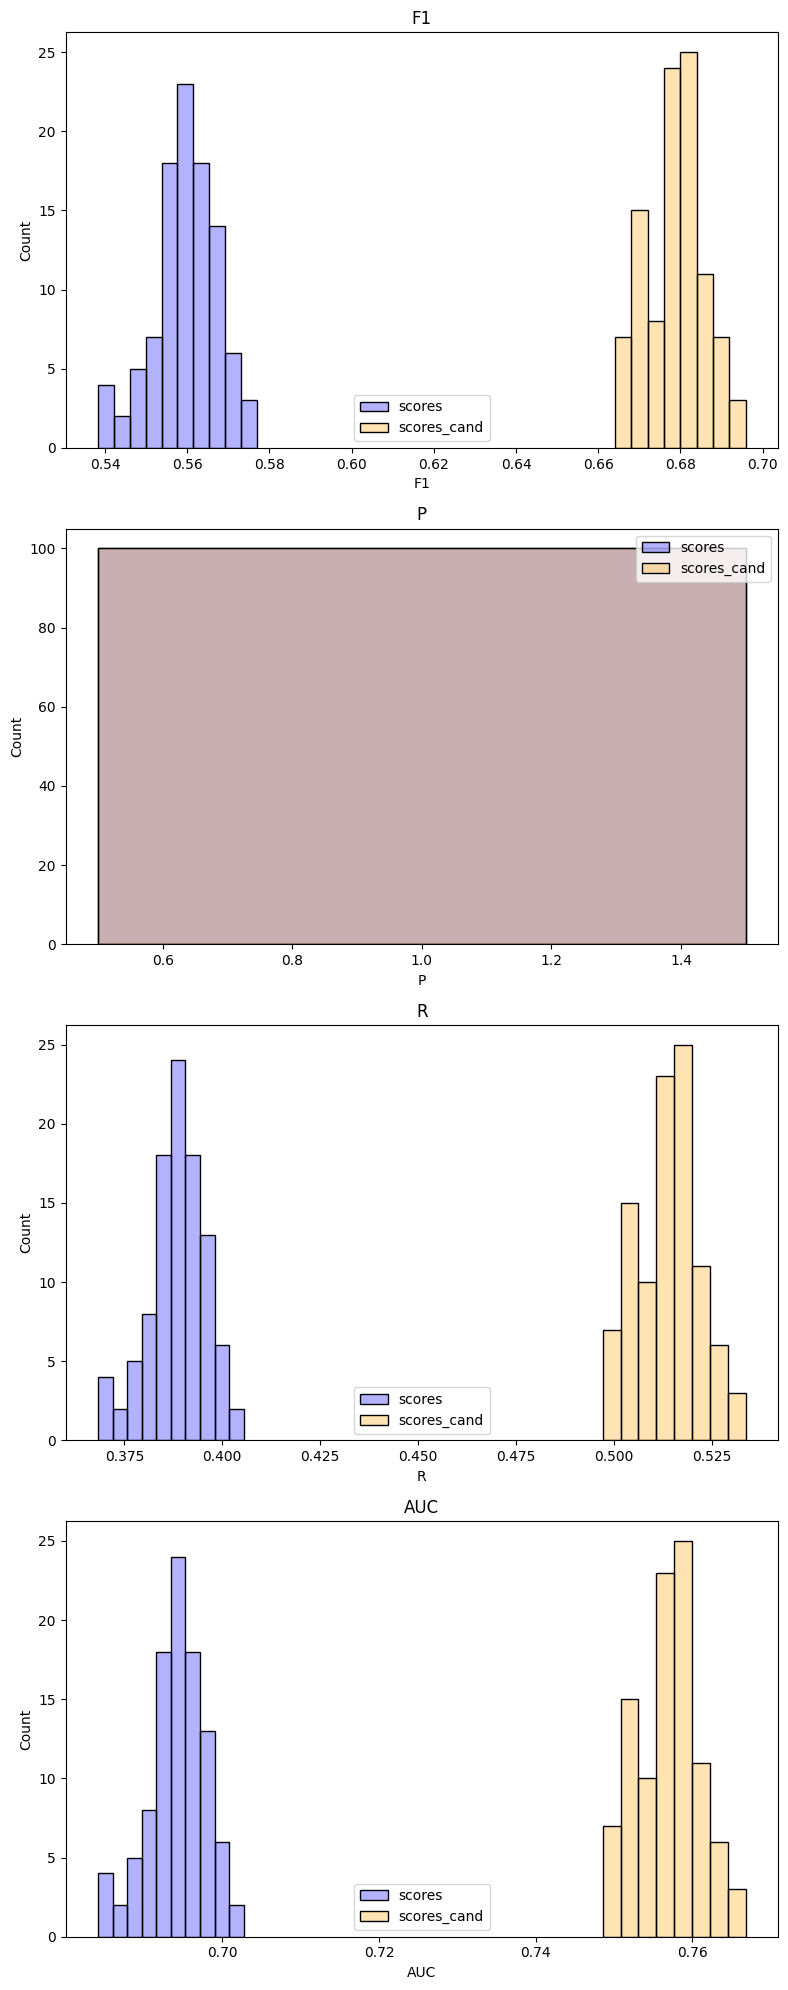

In [45]:
# Loop through the columns
columns_to_plot = ['F1', 'P', 'R', 'AUC']

# Create a figure and axis for the plot
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(8, 5*len(columns_to_plot)))


for i, column in enumerate(columns_to_plot):
    # Plot histograms for each dataset
    sns.histplot(data=scores, x=column, ax=axes[i], color='blue', label='scores', alpha=0.3)
    sns.histplot(data=scores_cand, x=column, ax=axes[i], color='orange', label='scores_cand', alpha=0.3)

    # Set plot labels and titles
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'{column}')

    # Add legend
    axes[i].legend()

# Adjust the layout
plt.tight_layout()

plt.gcf()
plt.savefig("cands.png", transparent=True)

# Show the plot
plt.show()

In [42]:
alpha = 0.01

for name in ['F1', 'P']:
    # p-value for F1 score
    pvalue = ttest_ind(scores[name], scores_cand[name]).pvalue

    print(f"p-value ({name}): {pvalue:g}\t-\t", end='')
    if pvalue < alpha:
        print("Reject null hypothesis.")
    else:
        print("Accept null hypothesis.")


p-value (F1): 9.26013e-181	-	Reject null hypothesis.
p-value (P): nan	-	Accept null hypothesis.


Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


In [47]:
import numpy as np
mean = scores['F1'].mean()
std_error = scores['F1'].std() / np.sqrt(len(scores['F1']))
confidence_level = 0.95

confidence_interval = stats.t.interval(confidence_level, len(scores)-1, mean, std_error)
print(f'Confidence interval for F1: {confidence_interval[0]:.4f} <- {scores["F1"].mean():.4f} -> {confidence_interval[1]:.4f}')


Confidence interval for F1: 0.5579 <- 0.5595 -> 0.5610


## Интерпретация предсказаний

Рассмотрим результат анализа с помощью SHAP

In [50]:
df1[(df1["y_test"] == 1) & (df1["y_pred"] == 0)].head()

,y_test,y_pred
13,1,0
31,1,0
56,1,0
57,1,0
125,1,0


In [ ]:
random_search_res

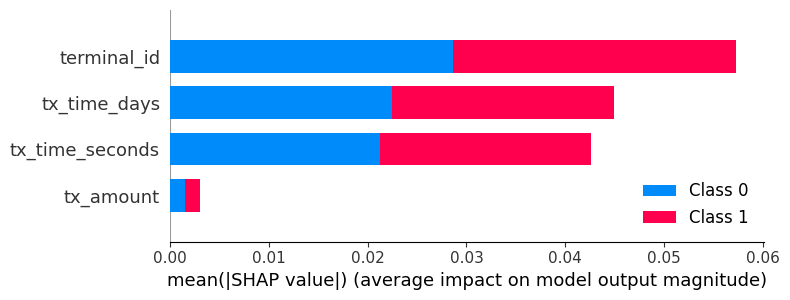

In [62]:
shap_values_Tree_tr = shap.TreeExplainer(pipe.named_steps["classifier"]).shap_values(X_train)
shap.summary_plot(shap_values_Tree_tr, X_train)

plt.gcf()
plt.savefig("shap_interpret.png", transparent=True)